In [89]:
import pandas as pd
import numpy as np

import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from tqdm.notebook import tqdm

import ast

from fa2 import ForceAtlas2

import nltk

import re

import utils

import random

In [2]:
tqdm.pandas()

In [3]:
df = pd.read_csv("../data/marvel_teams.csv")

df["members"] = df["members"].apply(ast.literal_eval)

df.head()

,team_name,members
0,Oracle Inc. (Earth-616),"[Anita Savvy (Earth-616), Caleb Alexander (Ear..."
1,Metal Mobsters (Earth-616),[]
2,Knights of the Atomic Round Table (Earth-616),"[Anthony Stark (Earth-616), Bruce Banner (Eart..."
3,Yoruba,[]
4,Emissaries of Evil (Electro) (Earth-616),"[Manuel Eloganto (Earth-616), Maxwell Dillon (..."


In [4]:
all_characters = []
for _, row in tqdm(df.iterrows()):
  for member in row["members"]:
    all_characters += [(member, row["team_name"])]
all_characters[:5]

0it [00:00, ?it/s]

[('Anita Savvy (Earth-616)', 'Oracle Inc. (Earth-616)'),
 ('Caleb Alexander (Earth-616)', 'Oracle Inc. (Earth-616)'),
 ('Carrie Alexander (Earth-616)', 'Oracle Inc. (Earth-616)'),
 ('Jacqueline Falsworth (Earth-616)', 'Oracle Inc. (Earth-616)'),
 ('Jim Hammond (Earth-616)', 'Oracle Inc. (Earth-616)')]

In [5]:
df_char = pd.DataFrame(all_characters, columns=["name", "team"])

df_char = df_char.groupby("name")["team"].progress_apply(list).to_frame("teams").reset_index()
df_char["number_teams"] = df_char["teams"].progress_apply(len)

df_char

  0%|          | 0/12298 [00:00<?, ?it/s]

  0%|          | 0/12298 [00:00<?, ?it/s]

,name,teams,number_teams
0,'Spinner (Earth-616),[Galactic Alliance of Spider-Men (Earth-616)],1
1,101st Airborne Division (Earth-616),[United States Army (Earth-616)],1
2,107 (Earth-616),[Psigns of the Times (Earth-616)],1
3,11-Ball (Earth-616),[8-Ball's Gang (Earth-616)],1
4,14 (Earth-616),[Psigns of the Times (Earth-616)],1
...,...,...,...
12293,Zymo (Eurth) (Earth-616),[Minions of Evil (Eurth) (Earth-616)],1
12294,Zyro (Earth-616),[Imperial Kree Army (Earth-616)],1
12295,Zyziwc Tiel (Earth-616),[Nova Corps (Earth-616)],1
12296,Zzzax (Earth-616),[Trouble (Team) (Earth-616)],1


In [6]:
df_char.sort_values("number_teams", ascending=False).reset_index(drop=True)

,name,teams,number_teams
0,James Howlett (Earth-616),"[Swordbearers of Krakoa (Earth-616), Clan Yash...",31
1,Peter Parker (Earth-616),"[Frightful Four (Earth-616), Daily Bugle (Fron...",31
2,Anthony Stark (Earth-616),[Knights of the Atomic Round Table (Earth-616)...,26
3,Ororo Munroe (Earth-616),"[Quiet Council of Krakoa (Earth-616), Swordbea...",25
4,Henry McCoy (Earth-616),"[X-Factor (Earth-616), Acolytes (Earth-616), X...",24
...,...,...,...
12293,Gadriel (Grigori) (Earth-616),[Grigori (Angels) (Earth-616)],1
12294,Gaeric (Earth-616),[Black Legions (Aquilonia) (Earth-616)],1
12295,Gah-Ran (Earth-616),[Equal Rights For Every Intelligence (Earth-616)],1
12296,Gahck (Earth-616),[Tribe of Fire (Earth-616)],1


In [7]:
def getQuotes(row):
  quotes = []
  filename= utils.generate_filename(row["name"])
  try:
    with open("../data/character_quotes/"+filename+".json") as f:
      quotes += ast.literal_eval(f.read())
  except:
    pass
  
  return pd.Series([quotes, len(quotes)])


df_char[["quotes", "number_quotes"]] = df_char.progress_apply(getQuotes, axis=1)
df_char.head()

  0%|          | 0/12298 [00:00<?, ?it/s]

,name,teams,number_teams,quotes,number_quotes
0,'Spinner (Earth-616),[Galactic Alliance of Spider-Men (Earth-616)],1,[],0
1,101st Airborne Division (Earth-616),[United States Army (Earth-616)],1,[],0
2,107 (Earth-616),[Psigns of the Times (Earth-616)],1,[],0
3,11-Ball (Earth-616),[8-Ball's Gang (Earth-616)],1,[],0
4,14 (Earth-616),[Psigns of the Times (Earth-616)],1,[],0


In [8]:
df_char.sort_values("number_quotes", ascending=False).reset_index(drop=True)

,name,teams,number_teams,quotes,number_quotes
0,Peter Parker (Earth-616),"[Frightful Four (Earth-616), Daily Bugle (Fron...",31,[Adoma. Congratulations. You just became the f...,666
1,Steven Rogers (Earth-616),"[Invaders (WWII) (Earth-616), United States Ar...",17,[They should be proud to have her as a student...,432
2,Anthony Stark (Earth-616),[Knights of the Atomic Round Table (Earth-616)...,26,[There's only two things I ever managed to bel...,381
3,James Howlett (Earth-616),"[Swordbearers of Krakoa (Earth-616), Clan Yash...",31,"[There ain't no sense to it, babe. There's nev...",337
4,Wade Wilson (Earth-616),"[Frightful Four (Earth-616), Agency X (Earth-6...",24,[It's an angel of God. My glorious Bea Arthur-...,287
...,...,...,...,...,...
12293,Four (Eugenix) (Earth-616),[Eugenix (Earth-616)],1,[],0
12294,Four Winds (Elektra Foes) (Earth-616),[Triads (Earth-616)],1,[],0
12295,Foxbat (Earth-616),"[Dark Riders (Earth-616), House of Agon (Earth...",2,[],0
12296,Foxtrot (Wild Pack) (Earth-616),[Wild Pack (Earth-616)],1,[],0


In [9]:
def getLexicalRichness(row):
  regex_links = r"(?:\{\{.*?\}\}|\[\[.*?\]\])"
  regex_newline = r"\\n"
  regex_no_alpha = r"[^a-zA-Z ]"
  regex_aditional_space = r"\s\s+"
  text = " ".join(row["quotes"])
  text = re.sub(regex_links, "", text)
  text = re.sub(regex_newline, " ", text)
  text = re.sub(regex_no_alpha, " ", text)
  text = re.sub(regex_aditional_space, " ", text)
  words = [word for word in text.lower().split(" ") if len(word) > 1]
  number_words = len(words)
  number_unique_words = len(list(set(words)))
  lexical_richness = 0
  if number_words > 0:
    lexical_richness = number_unique_words/number_words
  return pd.Series([number_words, number_unique_words, lexical_richness])
  
  
df_char[["number_words",
         "number_unique_words",
         "lexical_richness"]] = df_char.progress_apply(getLexicalRichness, axis=1)
df_char.head()

  0%|          | 0/12298 [00:00<?, ?it/s]

,name,teams,number_teams,quotes,number_quotes,number_words,number_unique_words,lexical_richness
0,'Spinner (Earth-616),[Galactic Alliance of Spider-Men (Earth-616)],1,[],0,0.0,0.0,0.0
1,101st Airborne Division (Earth-616),[United States Army (Earth-616)],1,[],0,0.0,0.0,0.0
2,107 (Earth-616),[Psigns of the Times (Earth-616)],1,[],0,0.0,0.0,0.0
3,11-Ball (Earth-616),[8-Ball's Gang (Earth-616)],1,[],0,0.0,0.0,0.0
4,14 (Earth-616),[Psigns of the Times (Earth-616)],1,[],0,0.0,0.0,0.0


In [10]:
df_char[df_char["lexical_richness"] < 1].sort_values("lexical_richness", ascending=False).reset_index(drop=True)

,name,teams,number_teams,quotes,number_quotes,number_words,number_unique_words,lexical_richness
0,Hades (Earth-616),"[Hell Lords (Earth-616), Lords of the Splinter...",3,[There stands not a god alive who dares deny P...,2,33.0,32.0,0.969697
1,Katherine Farrell (Earth-616),"[Daily Bugle (Front Line) (Earth-616), Daily B...",2,[I'd hate to see my first big story come back ...,1,33.0,32.0,0.969697
2,Trigger Bolo (Earth-616),[Six Big Men (Earth-616)],1,[I-I'm sorry Lil!! I-I'm just kinda jittery an...,2,29.0,28.0,0.965517
3,H.E.L.E.N. (Earth-616),[Stark Industries (Earth-616)],1,[Wow! All these shiny new processors? Forget d...,1,29.0,28.0,0.965517
4,Benazir Kaur (Earth-616),[Hellfire Club (Earth-616)],1,[[[Shinobi Shaw (Earth-616)|Your]] king's head...,1,29.0,28.0,0.965517
...,...,...,...,...,...,...,...,...
11946,Fireflyte (Earth-616),[Micronauts (Earth-616)],1,[],0,0.0,0.0,0.000000
11947,Firestryke (Earth-616),[Q7 Strike Force (Earth-616)],1,[],0,0.0,0.0,0.000000
11948,First of the Flames (Earth-616),[Congress of Worlds (Earth-616)],1,[],0,0.0,0.0,0.000000
11949,Fish Face Friday (Earth-616),[United States Army (Earth-616)],1,[],0,0.0,0.0,0.000000


In [11]:
def getVaderSentiment(row):
  sid_obj = SentimentIntensityAnalyzer()
  
  happy = []
  sad = []
  neutral = []
  compound = []
  category = []
  
  for quote in row["quotes"]:
    sentiment_dict = sid_obj.polarity_scores(quote)
    happy.append(sentiment_dict["pos"])
    sad.append(sentiment_dict["neg"])
    neutral.append(sentiment_dict["neu"])
    compound.append(sentiment_dict["compound"])
    
    if sentiment_dict['compound'] >= 0.05:
        category.append("Positive")
 
    elif sentiment_dict['compound'] <= - 0.05:
        category.append("Negative")
 
    else:
        category.append("Neutral")
  if len(row["quotes"]) == 0:
    return pd.Series([0, 0, 0, 0, "Neutral"])
  
  happy_val = sum(happy)/len(happy)
  sad_val = sum(sad)/len(sad)
  neutral_val = sum(neutral)/len(neutral)
  compound_val = sum(compound)/len(compound)
  category_val = max(category, key=category.count)
  return pd.Series([happy_val*100, sad_val*100, neutral_val*100, compound_val, category_val])
    

df_char[["%happy",
         "%sad",
         "%neutral",
         "compound_sentiment",
         "overall_category"]] = df_char.progress_apply(getVaderSentiment, axis=1)

df_char

  0%|          | 0/12298 [00:00<?, ?it/s]

,name,teams,number_teams,quotes,number_quotes,number_words,number_unique_words,lexical_richness,%happy,%sad,%neutral,compound_sentiment,overall_category
0,'Spinner (Earth-616),[Galactic Alliance of Spider-Men (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
1,101st Airborne Division (Earth-616),[United States Army (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
2,107 (Earth-616),[Psigns of the Times (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
3,11-Ball (Earth-616),[8-Ball's Gang (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
4,14 (Earth-616),[Psigns of the Times (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12293,Zymo (Eurth) (Earth-616),[Minions of Evil (Eurth) (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
12294,Zyro (Earth-616),[Imperial Kree Army (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
12295,Zyziwc Tiel (Earth-616),[Nova Corps (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
12296,Zzzax (Earth-616),[Trouble (Team) (Earth-616)],1,[Me ZZax!!],1,2.0,2.0,1.0,0.0,0.0,100.0,0.0,Neutral


In [14]:
df_char.sort_values("%happy", ascending=False).reset_index(drop=True).head()

,name,teams,number_teams,quotes,number_quotes,number_words,number_unique_words,lexical_richness,%happy,%sad,%neutral,compound_sentiment,overall_category
0,Jennifer Kale (Earth-616),"[50-State Initiative (Earth-616), Command (Ear...",5,[God forgive me.],1,3.0,3.0,1.000000,80.8,0.0,19.2,0.4939,Positive
1,Ronald Parvenue (Earth-616),[Hellfire Club (Earth-616)],1,[Happy hunting.],1,2.0,2.0,1.000000,78.7,0.0,21.3,0.5719,Positive
2,Kharsa (Earth-616),[Swift Tide (Earth-616)],1,"[Well. '''Well,''' well, well. Where shall [[S...",1,7.0,4.0,0.571429,67.1,0.0,32.9,0.8020,Positive
3,Herman Frayne (Earth-616),[Hydro-Men (Earth-616)],1,"['''Welcome''', friends, to Hydrobase--your la...",1,9.0,9.0,1.000000,62.4,13.3,24.2,0.8442,Positive
4,Planet Terry (Terry) (Earth-616),[Ravagers (Earth-616)],1,"[Good luck flying, [[Robota (Earth-616)|Robota...",1,9.0,9.0,1.000000,60.3,0.0,39.7,0.9286,Positive


In [15]:
df_char.sort_values("%sad", ascending=False).reset_index(drop=True).head()

,name,teams,number_teams,quotes,number_quotes,number_words,number_unique_words,lexical_richness,%happy,%sad,%neutral,compound_sentiment,overall_category
0,Molly Fitzgerald (Earth-616),"[Strategic Homeland Intervention, Enforcement ...",1,"[Poor, poor '''[[Ireland]]!''']",1,2.0,1.0,0.5,0.0,86.7,13.3,-0.7574,Negative
1,Hux (Earth-616),[Lovelace Army (Earth-616)],1,['''Fight for the fallen!'''],1,4.0,4.0,1.0,0.0,72.9,27.1,-0.6588,Negative
2,Mairead (Earth-616),[Lovelace Army (Earth-616)],1,[Death to [[Dimitrios (Earth-616)|Dimitrios]]!],1,2.0,2.0,1.0,0.0,58.3,41.7,-0.6360,Negative
3,M-11 (Earth-616),"[Atlas Foundation (Earth-616), Department Zero...",4,"[Crush. <b>Kill. DESTROY!!!!</b>, Crush. <b>Ki...",2,6.0,3.0,0.5,0.0,58.1,41.9,-0.4153,Negative
4,Laslo Magzel (Earth-616),[Rush Club (Earth-616)],1,[Pitiful Fools! Do you not recognize me?],1,7.0,7.0,1.0,0.0,57.2,42.8,-0.7712,Negative


In [16]:
df_char.sort_values("%neutral", ascending=False).reset_index(drop=True).head()

,name,teams,number_teams,quotes,number_quotes,number_words,number_unique_words,lexical_richness,%happy,%sad,%neutral,compound_sentiment,overall_category
0,Jeryn Hogarth (Earth-616),"[Chicago Spectator (Earth-616), Rand Corporati...",3,['''[[Daniel Rand (Earth-616)|Danny]]''' are y...,1,10.0,10.0,1.000000,0.0,0.0,100.0,0.0,Neutral
1,Arkea (Earth-616),"[Prime Sentinels (Earth-616), Sisterhood of Mu...",2,[Arkea Prime. I've returned. [[Karima Shapanda...,1,6.0,6.0,1.000000,0.0,0.0,100.0,0.0,Neutral
2,Spymaster (Ted Calloway) (Earth-616),"[Advanced Idea Mechanics (Earth-616), Roxxon E...",4,"[The Spy-Master always delivers!, There is muc...",2,14.0,14.0,1.000000,0.0,0.0,100.0,0.0,Neutral
3,Christoph Nord (Earth-616),"[Team X (Earth-616), Weapon X (Earth-616), Cen...",3,"[So I'm going to level with you, [[James Howle...",1,6.0,6.0,1.000000,0.0,0.0,100.0,0.0,Neutral
4,Masked Raider III (Earth-616),[Defenders (Earth-616)],1,[This all '''started''' with the '''[[Jim Hamm...,3,31.0,16.0,0.516129,0.0,0.0,100.0,0.0,Neutral


In [17]:
df_char.sort_values("compound_sentiment", ascending=False).reset_index(drop=True).head()

,name,teams,number_teams,quotes,number_quotes,number_words,number_unique_words,lexical_richness,%happy,%sad,%neutral,compound_sentiment,overall_category
0,Victor Stein (Earth-616),[Pride (Earth-616)],1,[The twelve of us joined [[Pride (Earth-616)|T...,1,150.0,106.0,0.706667,17.00,4.9,78.10,0.9582,Positive
1,Aikku Jokinen (Earth-616),"[Avengers Idea Mechanics (Earth-616), Advanced...",7,[When I was in '''[[Planetary Operational Defe...,1,63.0,44.0,0.698413,20.00,0.0,80.00,0.9453,Positive
2,Gullivar Jones (Earth-616),[United States Marine Corps (Earth-616)],1,[...Mars was '''not''' Earth... I had not seen...,1,35.0,32.0,0.914286,29.70,3.4,66.80,0.9393,Positive
3,William Adams (Earth-616),"[Unwanted (Earth-616), United States Army (Ear...",2,"[My name is William ""Bud"" Connor. I was once o...",1,52.0,47.0,0.903846,25.80,4.1,70.10,0.9338,Positive
4,Poseidon Aegaeus (Earth-616),[Olympus Group (Earth-616)],1,"['''Arise,''' my brave, beautiful '''Namora......",2,66.0,29.0,0.439394,32.35,0.0,67.65,0.9337,Positive


In [18]:
df_char.sort_values("compound_sentiment", ascending=True).reset_index(drop=True).head()

,name,teams,number_teams,quotes,number_quotes,number_words,number_unique_words,lexical_richness,%happy,%sad,%neutral,compound_sentiment,overall_category
0,Dennis Wells (Earth-616),[Federal Bureau of Investigation (Earth-616)],1,[All Right. This is strictly off the record. I...,1,63.0,53.0,0.841270,0.0,29.0,71.0,-0.9767,Negative
1,Edan Younge (Earth-616),[Phoenix Corporation (Earth-616)],1,[It was with us from the start... Our curiosit...,2,212.0,79.0,0.372642,3.3,19.5,77.2,-0.9726,Negative
2,Robert Nicolle (Earth-616),[Unkillables (Earth-616)],1,"[Man, I hate [[James Howlett (Earth-616)|you]]...",1,108.0,59.0,0.546296,6.9,20.3,72.8,-0.9717,Negative
3,Otherone (Earth-616),"[Black Bunny Brigade (Earth-616), West Spiral ...",2,[But if I really '''thought''' about it...blow...,2,114.0,42.0,0.368421,12.7,33.6,53.7,-0.9644,Negative
4,Kim Il Sung (Earth-616),[Marauders (Earth-616)],1,[Why the [[Hell]] am I in [[Alley|wherever the...,1,7.0,7.0,1.000000,5.4,45.5,49.1,-0.9601,Negative


In [32]:
def getWiki(row):
  filename= utils.generate_filename(row["name"])
  
  regex_links = r"(?:\{\{.*?\}\}|\[\[.*?\]\])"
  regex_newline = r"\\n"
  regex_no_alpha = r"[^a-zA-Z ]"
  regex_aditional_space = r"\s\s+"

  try:
    with open("../data/character_content/"+filename+".json") as f:
      wiki = f.read()
      wiki = re.sub(regex_links, "", wiki)
      wiki = re.sub(regex_newline, " ", wiki)
      wiki = re.sub(regex_no_alpha, " ", wiki)
      wiki = re.sub(regex_aditional_space, " ", wiki)
      return len(wiki.split(" "))
  except:
    return 0 

df_char["number_words_wiki"] = df_char.progress_apply(getWiki, axis=1)
df_char

  0%|          | 0/12298 [00:00<?, ?it/s]

,name,teams,number_teams,quotes,number_quotes,number_words,number_unique_words,lexical_richness,%happy,%sad,%neutral,compound_sentiment,overall_category,number_words_wiki
0,'Spinner (Earth-616),[Galactic Alliance of Spider-Men (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,143
1,101st Airborne Division (Earth-616),[United States Army (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,0
2,107 (Earth-616),[Psigns of the Times (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,314
3,11-Ball (Earth-616),[8-Ball's Gang (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,115
4,14 (Earth-616),[Psigns of the Times (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12293,Zymo (Eurth) (Earth-616),[Minions of Evil (Eurth) (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,83
12294,Zyro (Earth-616),[Imperial Kree Army (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,78
12295,Zyziwc Tiel (Earth-616),[Nova Corps (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,89
12296,Zzzax (Earth-616),[Trouble (Team) (Earth-616)],1,[Me ZZax!!],1,2.0,2.0,1.0,0.0,0.0,100.0,0.0,Neutral,1667


In [35]:
df_char.sort_values("number_words_wiki", ascending=False).reset_index(drop=True).head()

,name,teams,number_teams,quotes,number_quotes,number_words,number_unique_words,lexical_richness,%happy,%sad,%neutral,compound_sentiment,overall_category,number_words_wiki
0,Bruce Banner (Earth-616),[Knights of the Atomic Round Table (Earth-616)...,22,[The '''angrier''' I get the '''stronger''' I ...,227,4441.0,1084.0,0.244089,10.081498,13.352863,76.127753,-0.077481,Negative,29980
1,James Howlett (Earth-616),"[Swordbearers of Krakoa (Earth-616), Clan Yash...",31,"[There ain't no sense to it, babe. There's nev...",337,7111.0,1495.0,0.210238,10.114540,11.525223,77.768843,-0.053218,Negative,24102
2,Peter Parker (Earth-616),"[Frightful Four (Earth-616), Daily Bugle (Fron...",31,[Adoma. Congratulations. You just became the f...,666,16365.0,2554.0,0.156065,11.003453,9.436186,78.661862,0.056899,Positive,22341
3,William Baker (Earth-616),"[Frightful Four (Earth-616), Avengers (Earth-6...",8,[When I saw those [[Astonishing Avengers (Eart...,8,154.0,101.0,0.655844,14.112500,13.312500,72.575000,0.154537,Positive,19422
4,Anthony Stark (Earth-616),[Knights of the Atomic Round Table (Earth-616)...,26,[There's only two things I ever managed to bel...,381,7053.0,1623.0,0.230115,10.003412,10.945669,78.791076,-0.030257,Negative,18039


In [125]:
def getLinks(row):
  filename= utils.generate_filename(row["name"])
  
  regex_links = r"(:?{{[^\\n]*?(:?|\|.*?)}}|\[\[(.*?)(:?|\|.*?)\]\])"
  links = []
  try:
    with open("../data/character_content/"+filename+".json") as f:
      wiki = f.read()
      links = re.findall(regex_links, wiki)
      links = [x[1] + x[2] for x in links
               if (x[1] in df_char["name"].values
                   or x[2] in df_char["name"].values)
               and x[1] != row["name"]
               and x[2] != row["name"]]
      links = list(set(links))
  except:
    pass
  return pd.Series([links, len(links)])

df_char[["links", "number_links"]] = df_char.progress_apply(getLinks, axis=1)
df_char.head()

  0%|          | 0/12298 [00:00<?, ?it/s]

,name,teams,number_teams,quotes,number_quotes,number_words,number_unique_words,lexical_richness,%happy,%sad,%neutral,compound_sentiment,overall_category,number_words_wiki,links,number_links
0,'Spinner (Earth-616),[Galactic Alliance of Spider-Men (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,143,[],0
1,101st Airborne Division (Earth-616),[United States Army (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,0,[],0
2,107 (Earth-616),[Psigns of the Times (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,314,[Vance Astrovik (Earth-616)],1
3,11-Ball (Earth-616),[8-Ball's Gang (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,115,"[Jeff Hagees (Earth-616), Sleepwalker (Earth-6...",2
4,14 (Earth-616),[Psigns of the Times (Earth-616)],1,[],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,245,[Vance Astrovik (Earth-616)],1


In [126]:
df_char.sort_values("number_links", ascending=False).reset_index(drop=True).head()

,name,teams,number_teams,quotes,number_quotes,number_words,number_unique_words,lexical_richness,%happy,%sad,%neutral,compound_sentiment,overall_category,number_words_wiki,links,number_links
0,Krakoa (Earth-616),[Quiet Council of Krakoa (Earth-616)],1,[],0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Neutral,1625,"[Michael McCain (Earth-616), Arakko (Earth-616...",285
1,James Howlett (Earth-616),"[Swordbearers of Krakoa (Earth-616), Clan Yash...",31,"[There ain't no sense to it, babe. There's nev...",337,7111.0,1495.0,0.210238,10.114540,11.525223,77.768843,-0.053218,Negative,24102,"[Cannon Foot (Earth-616), Elektra Natchios (Ea...",217
2,Bruce Banner (Earth-616),[Knights of the Atomic Round Table (Earth-616)...,22,[The '''angrier''' I get the '''stronger''' I ...,227,4441.0,1084.0,0.244089,10.081498,13.352863,76.127753,-0.077481,Negative,29980,"[Lyra (Earth-8009), Henry Gyrich (Earth-616), ...",215
3,William Baker (Earth-616),"[Frightful Four (Earth-616), Avengers (Earth-6...",8,[When I saw those [[Astonishing Avengers (Eart...,8,154.0,101.0,0.655844,14.112500,13.312500,72.575000,0.154537,Positive,19422,"[Herman Schultz (Earth-616), Medusalith Amaque...",180
4,Peter Parker (Earth-616),"[Frightful Four (Earth-616), Daily Bugle (Fron...",31,[Adoma. Congratulations. You just became the f...,666,16365.0,2554.0,0.156065,11.003453,9.436186,78.661862,0.056899,Positive,22341,"[Herman Schultz (Earth-616), Knull (Earth-616)...",164


In [127]:
G = nx.Graph()

G.add_nodes_from(df_char["name"])
for _, row in df_char.iterrows():
  G.add_edges_from([[row["name"], x] for x in row["links"]])

In [128]:
len(G.nodes), len(G.edges), sum([x[1] for x in G.degree])/len(G.nodes)

(12298, 51532, 8.380549682875264)

In [129]:
GCC = G.subgraph(max(nx.connected_components(G), key=len))

len(GCC.nodes()), len(GCC.edges()), sum([x[1] for x in GCC.degree])/len(GCC.nodes)

(8990, 51334, 11.420244716351501)

In [135]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=10.0,
                          strongGravityMode=True,
                          gravity=100.0,

                          # Log
                          verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=50)

100%|███████████████████████████████████████████| 50/50 [04:49<00:00,  5.79s/it]

BarnesHut Approximation  took  12.19  seconds
Repulsion forces  took  269.52  seconds
Gravitational forces  took  0.57  seconds
Attraction forces  took  5.60  seconds
AdjustSpeedAndApplyForces step  took  1.51  seconds


In [136]:
sizes = []
alphas = []
colors = []
max_degree = max(GCC.degree(), key=lambda x: x[1])[1]

for node in tqdm(GCC.nodes):
  size = GCC.degree(node) * 20 + 50
  alpha = max([GCC.degree(node)/max_degree, .2])
  
  colors.append((random.random(), random.random(), random.random()))
  
  sizes.append(size)
  alphas.append(alpha)

  0%|          | 0/8990 [00:00<?, ?it/s]

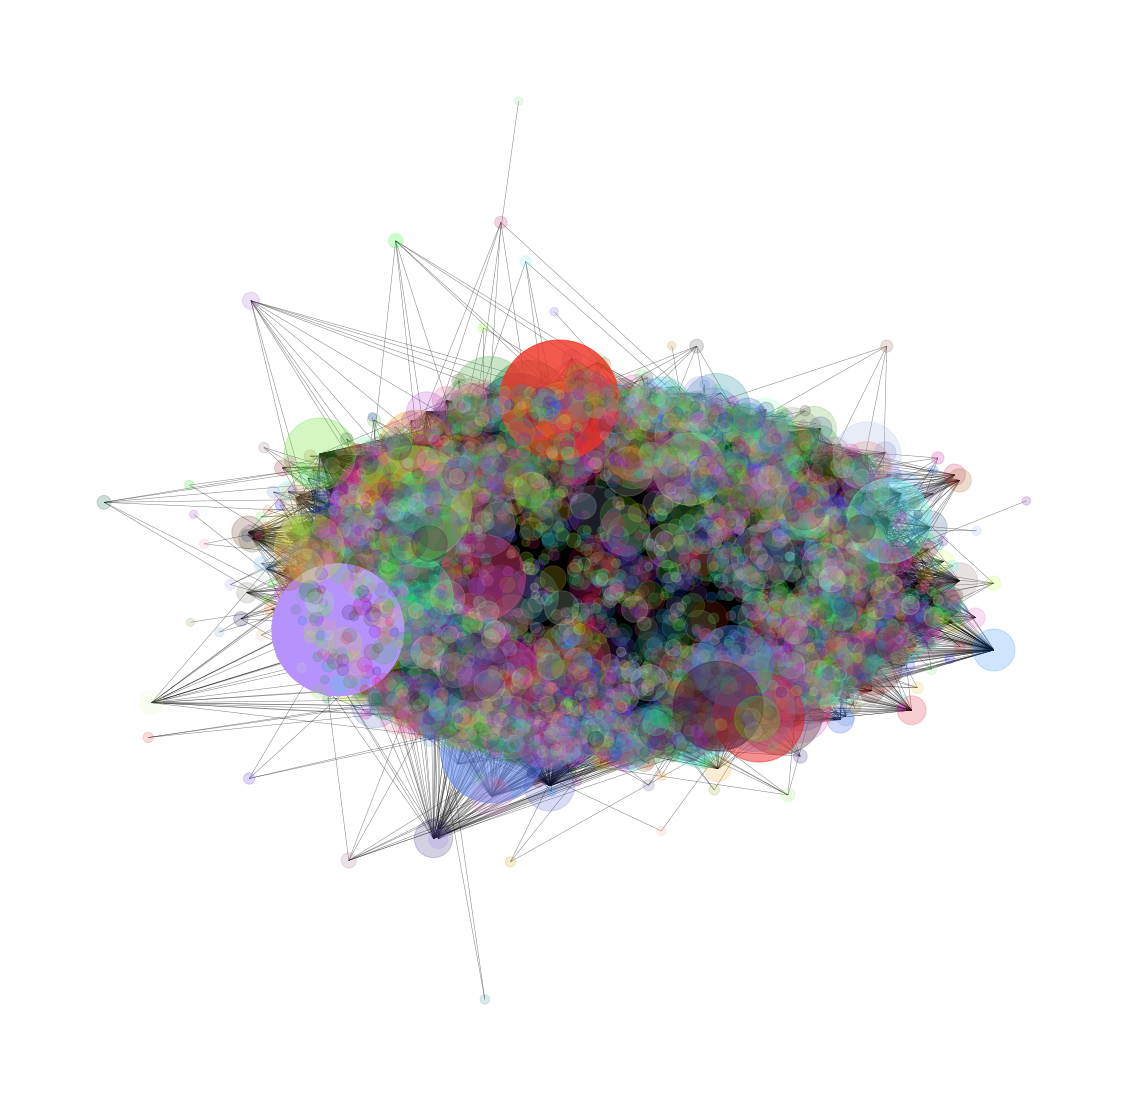

In [137]:
fig, ax = plt.subplots(figsize=(20, 20))

nx.draw_networkx_nodes(GCC,
                       positions,
                       linewidths  = 1,
                       node_size   = sizes,
                       node_color  = colors,
                       alpha       = alphas,
                       ax          = ax
                      )

nx.draw_networkx_edges(GCC,
                       positions,
                       edge_color  = "black",
                       arrowstyle  = "-",
                       alpha       = 0.5,
                       width       = .5,
                       ax          = ax
                      )  
plt.axis("off")

plt.show()

In [ ]:
def getAlias(row):
  filename= utils.generate_filename(row["name"])

  regex_alias = r"\|\sCurrentAlias\s+=\s(.*?)\\n"
  regex_alphanum = r"[^a-zA-Z0-9\- ]"
  regex_spaces = r"\s\s+"
  try:
    with open("../data/character_content/"+filename+".json") as f:
      wiki = f.read()
      alias = re.findall(regex_alias, wiki)[0]
      alias = re.sub(regex_alphanum, "", alias)
      alias = re.sub(regex_spaces, " ", alias)
      letters_alias = [x for x in alias if x != " "]
      if len(letters_alias) == 0:
        alias = "-"
      return alias.rstrip()
  except:
    return "-"

df_char["alias"] = df_char.progress_apply(getAlias, axis=1)
df_char

In [ ]:
def getDegree(row):
  return G.degree(row["name"])
  
df_char["degree"] = df_char.progress_apply(getDegree, axis=1)

In [ ]:
df_char[df_char["name"] == "James Howlett (Earth-616)"]